Hmmmm, It seems like all the information I need (e.g. chromosome number and position) is contained within the transcript type objects from plastid,but how do I extract that information. 

Perhaps for the fly data I can just take the first little part of the name when converted to a string to get the chromosome and then add on the region from attributes? Maybe an even smarter way would be to just say save everything until there is a semicolon since that is when it switches? 

For the ecoli data, this might be considerably easier because there is only one chromosome. 

Oh crud, what am I going to do about transcripts of differing lengths???

### Import the necessary packages

In [111]:
# Import necessary packages
from plastid import BAMGenomeArray,GTF2_TranscriptAssembler,Transcript, ThreePrimeMapFactory
import numpy as np
import pandas as pd
import dif_utils as dif
from plastid.plotting.plots import *
import setup_utils as st
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

### Define extra functions

In [68]:
def find_transcript(gene,transcripts):
    '''
    A function that takes the name of a gene as input and finds 
    the corresponding transcript from a transcript list. 
    
    returns both the transcript in question and the vector of counts for that transcript.
    
    This function is still a work in progress as for now it simply gives the last 
    transcript in the list that matches the gene ID. 
    '''
    
    for i in transcripts:
        if i.attr['transcript_biotype'] == 'protein_coding':
            if i.attr['gene_name'] == gene:
                my_transcript = i
                
    return my_transcript

### Define Paths

In [126]:
# Define the path to important files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/seq/"
gtf_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/genome/"
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/seq/'

### Set the random seed

In [49]:
np.random.seed(123)

### Load in transcripts and remove non protein coding tanscripts

In [52]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(gtf_path + "Drosophila_melanogaster.BDGP6.32.103.gtf"),
                                                     return_type=Transcript))

In [53]:
protein_coding = []
for transcript in transcripts:
    if transcript.attr['transcript_biotype'] == 'protein_coding':
        protein_coding.append(transcript)
transcripts = np.array(protein_coding, dtype = object)

In [66]:
#504 and 505 are different transcripts of the same gene with different lengths.
#If you want to test something you can do it on that. 

### Load up the target genes

In [67]:
# Load up the target gene names. 
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_ID"])

### Create the basis for the target portion of the bed file

In [74]:
chromo =[]
start =[]
end =[]
for gene in Fmr1_table["gene_ID"]:
    try:
        transcript = find_transcript(gene, transcripts)
    except:
        print(gene)
    chromo.append(str(transcript).partition(":")[0])
    start.append(transcript.attr['cds_genome_start'])
    end.append(transcript.attr['cds_genome_end'])

In [75]:
targets = pd.DataFrame(zip(chromo,start,end))
targets.columns = ["chr","start","stop"]

### Take random subsamples of all other transcripts

In [91]:
ran_tran = np.random.choice(transcripts, 1200)

In [92]:
chromo =[]
start =[]
end =[]
for transcript in ran_tran:
    chromo.append(str(transcript).partition(":")[0])
    start.append(transcript.attr['cds_genome_start'])
    end.append(transcript.attr['cds_genome_end'])

In [93]:
non_targets = pd.DataFrame(zip(chromo,start,end))
non_targets.columns = ["chr","start","stop"]

### Create and save the bed file.

In [94]:
to_bed = pd.concat([targets,non_targets])

In [97]:
to_bed.to_csv(save_path + "dmel_subset.bed", sep = "\t", header = False, index = False)

### Perform the subsetting

In [137]:
! cd /home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/seq/ && \
    samtools view -b -L dmel_subset.bed Fmr1_RPF_2_Aligned.sortedByCoord.out.bam > subset_Fmr1_RPF_2.bam && \
    samtools view -b -L dmel_subset.bed control_RPF_2_Aligned.sortedByCoord.out.bam > subset_control_RPF_2.bam && \
    samtools view -b -L dmel_subset.bed Fmr1_RNA_2_Aligned.sortedByCoord.out.bam > subset_Fmr1_RNA_2.bam && \
    samtools view -b -L dmel_subset.bed control_RNA_2_Aligned.sortedByCoord.out.bam > subset_control_RPF_2.bam && \
    samtools view -b -L dmel_subset.bed Fmr1_RPF_3_Aligned.sortedByCoord.out.bam > subset_Fmr1_RPF_3.bam && \
    samtools view -b -L dmel_subset.bed control_RPF_3_Aligned.sortedByCoord.out.bam > subset_control_RPF_3.bam && \
    samtools view -b -L dmel_subset.bed Fmr1_RNA_3_Aligned.sortedByCoord.out.bam > subset_Fmr1_RNA_3.bam && \
    samtools view -b -L dmel_subset.bed control_RNA_3_Aligned.sortedByCoord.out.bam > subset_control_RNA_3.bam

# Test Subset

In [104]:
# Read in the alignments from a BAM file and then have it map to the p-site 
alignments = BAMGenomeArray(data_path + "subset.bam")
alignments.set_mapping(ThreePrimeMapFactory(15))

In [105]:
# create a list to hold the vectors
count_vectors = []

# get counts for each transcript
for transcript in transcripts:
    count_vectors.append(transcript.get_counts(alignments))

---------------------------------------------------------------------------
UserWarning
Data contains read alignments shorter than offset (15 nt). Ignoring.
in /home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/plastid/util/services/exceptions.py, line 234:

232         filterwarnings("onceperfamily", message=pattern, category=category)
234     warn(message, category=category, stacklevel=stacklevel)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
UserWarning
Data contains read alignments shorter than offset (15 nt). Ignoring.
in /home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/plastid/util/services/exceptions.py, line 234:

232         filterwarnings("onceperfamily", message=pattern, category=category)
234     warn(message, category=category, stacklevel=stacklevel)

---------------------------------------------------------------------------
--------

In [108]:
len(count_vectors)

30710

In [113]:
x,g,i = dif.find_transcript("poe",list(transcripts), count_vectors)

(0.0, 0.006)

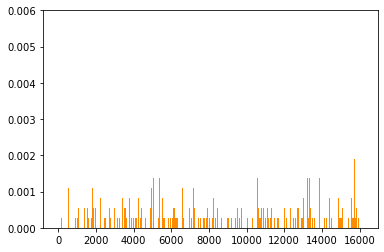

In [121]:
plt.bar(list(range(len(g))), g/sum(g), color = "darkorange", width = 4)
plt.ylim([0,0.006])

### This does not look quite right, could have been caused by the changes in P-site offsetting or any of a number of things. That being said, I thing I can view this as a success